In [1]:
from pyCapsid.PDB import getCapsid
pdb = '7kq5'
capsid, calphas, coords, bfactors, title = getCapsid(pdb)

Fetching file 1 / 1 (7kq5)...
Done


C:\Users\colin\miniconda3\envs\pycapsid\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
@> 4507 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Secondary structures were assigned to 195 residues.
@> Biomolecular transformations were applied to the coordinate data.


Number Of Residues:  15900


In [2]:
from pyCapsid.ENM import buildENM
kirch, hessian = buildENM(calphas, coords, cutoff=7.5, model='anm', fanm=0.1)

done constructing matrix


In [4]:
from pyCapsid.NMA import modeCalc
n_modes = 200
eigmethod = 'eigsh'
model = 'anm'

evals, evecs = modeCalc(kirch, n_modes, eigmethod, model, which='LA', sigma=1e-10)

Calculating Normal Modes
NMA time:  9.271648406982422


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                15900
Model:                            RLM   Df Residuals:                    15899
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 08 Jan 2023                                         
Time:                        14:17:29                                         
No. Iterations:                    25                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           155.8172      0.250    623.995      0.0

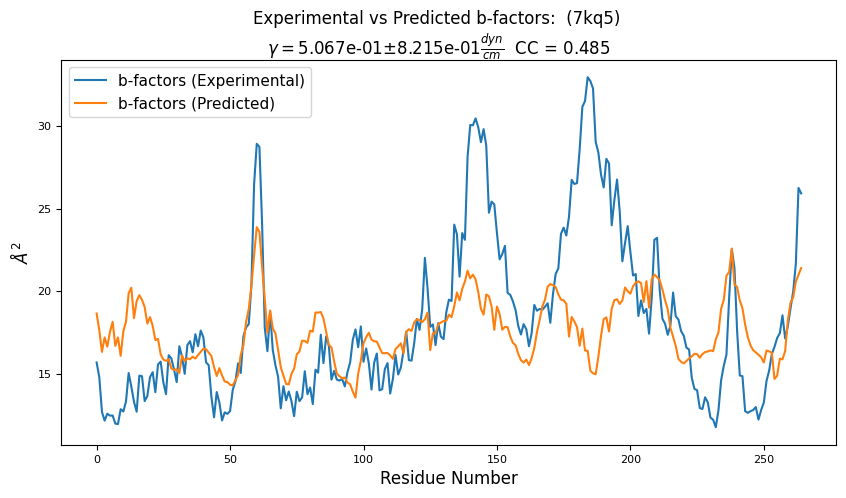

(0.4852628818239,
 155.81719144039099,
 0,
 array([18.65349315, 17.63385795, 16.3284167 , ..., 20.57536844,
        20.99962002, 21.39732573]),
 0.8214689998545737,
 array([0.]),
 0.0023900657980749918,
 200)

In [16]:
from pyCapsid.bfactorfit import plotBfactors
plotBfactors(evals, evecs, bfactors, pdb, is3d=False, fitModes=False, plotModes=True, forceIco=False, icotol=0.002)

In [ ]:
from pyCapsid.NMA import calcCovMat, calcDistFlucts
n_modes = 200
fluct_cutoff = 10
covariance = calcCovMat(evals, evecs, n_modes, coords, fluct_cutoff, is3d=False)
print(covariance.data)
dist_flucts = calcDistFlucts(evals, evecs, n_modes, coords, fluct_cutoff, is3d=False)
print(dist_flucts.data)

from pyCapsid.mechanical_analysis import fluctToSims
sims = fluctToSims(dist_flucts.copy())
sims.eliminate_zeros()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].spy(dist_flucts)
ax[1].spy(sims)
plt.show()

In [ ]:
from pyCapsid.NMA import fluctPlot
fluctPlot(dist_flucts, ' ', pdb)

In [ ]:
from pyCapsid.QRC import calcEmbedding, cluster_embedding
from pyCapsid import clustering_util
import numpy as np

n_cluster_max = 130
embedding = calcEmbedding(sims, n_cluster_max)

n_range = np.arange(4, n_cluster_max, 2)

labels, scores, variances, numtypes = cluster_embedding(n_range, embedding, method='discretize')

In [ ]:
from pyCapsid.clustering_util import plotScores
plotScores(pdb, n_range, scores, variances, numtypes)
clusters = labels[np.argmax(scores)]

In [ ]:
# Adapted from py3dmol tutorial
class Atom(dict):
    def __init__(self, line):
        self["type"] = line[0:6].strip()
        self["idx"] = line[6:11].strip()
        self["name"] = line[12:16].strip()
        self["resname"] = line[17:20].strip()
        self["resid"] = int(int(line[22:26]))
        self["x"] = float(line[30:38])
        self["y"] = float(line[38:46])
        self["z"] = float(line[46:54])
        self["sym"] = line[76:78].strip()

    def __str__(self):
        line = list(" " * 80)

        line[0:6] = self["type"].ljust(6)
        line[6:11] = self["idx"].ljust(5)
        line[12:16] = self["name"].ljust(4)
        line[17:20] = self["resname"].ljust(3)
        line[22:26] = str(self["resid"]).ljust(4)
        line[30:38] = str(self["x"]).rjust(8)
        line[38:46] = str(self["y"]).rjust(8)
        line[46:54] = str(self["z"]).rjust(8)
        line[76:78] = self["sym"].rjust(2)
        return "".join(line) + "\n"
    
class Molecule(list):
    def __init__(self, file):
        for line in file:
            if "ATOM" in line or "HETATM" in line:
                self.append(Atom(line))

    def __str__(self):
        outstr = ""
        for at in self:
            outstr += str(at)

        return outstr
    
# Colormap generation taken from stackexchange
# https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(number_of_distinct_colors: int = 80):
    import math

    import numpy as np
    from matplotlib.colors import ListedColormap
    from matplotlib.cm import hsv

    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [ ]:
with open(pdb + "_capsid.pdb") as ifile:
    mol = Molecule(ifile)

In [ ]:
import numpy as np
print(np.min(clusters))
print('labels: ', clusters.shape)

In [ ]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))
cmap = generate_colormap(int(np.max(clusters)))
print(cmap)
rgba = cmap(norm(clusters))
print(rgba*255)
hexcolor = []
for c in rgba:
    hexcolor.append(mpl.colors.rgb2hex(c))

In [ ]:
r0 = mol[0]['resid']
c0 = hexcolor[0]
#l0 = clusters[0]
#fullcolors = []
clust_scheme = []
select = '@'
print(r0, c0)
i = 1
j = 0
for at in mol:
    r = at['resid']
    if r == r0:
        select += str(i) + ','
        i += 1
    else:
        clust_scheme.append([c0, select[:-1]])
        select = '@' + str(i) + ','
        r0 = r
        j +=1
        i +=1
        c0 = hexcolor[j]
        l0 = clusters[j]
clust_scheme.append([c0, select[:-1]])

In [ ]:
import nglview as ngl
file = pdb + '_capsid.pdb'
color_scheme = ngl.color._ColorScheme(clust_scheme, label="scheme_regions")
view = ngl.show_prody(capsid, gui=False)
view.clear_representations()


view.add_representation("spacefill",  color=color_scheme)
view._remote_call("setSize", target='Widget', args=['1000px','1000px'])
view

In [ ]:
import nglview as ngl
file = pdb + '_capsid.pdb'
color_scheme = ngl.color._ColorScheme(clust_scheme, label="scheme_regions")
view = ngl.show_prody(capsid, gui=False)
view.clear_representations()


view.add_representation("cartoon",  color=color_scheme)
view._remote_call("setSize", target='Widget', args=['1000px','1000px'])
view

In [ ]:
import nglview as ngl
file = pdb + '_capsid.pdb'
color_scheme = ngl.color._ColorScheme(clust_scheme, label="scheme_regions")
view = ngl.show_prody(capsid, gui=False)
view.clear_representations()


view.add_representation("cartoon",  color=color_scheme)
view._remote_call("setSize", target='Widget', args=['1000px','1000px'])
view